In [41]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

def k_means(x,k):
    np.random.seed(1919)
    n,d=x.shape
    cent=x[np.random.choice(n,k,replace=False)]
    for _ in range(100):
        labels=np.argmin(np.linalg.norm(x[:,np.newaxis]-cent,axis=-1),axis=-1)
        new_cent=np.array([x[labels==i].mean(axis=0) for i in range(k)])

        if np.all(new_cent==cent):
            break
        cent=new_cent
    
    return labels

def gmm(x,k):
    np.random.seed(1919)
    n,d=x.shape
    labels=np.random.choice(k,n)
    pi=np.bincount(labels)/n
    mu=x[np.random.choice(n,k,replace=False)]
    sigma=np.array([np.cov(x[labels==i].T)+1e-6*np.eye(d) for i in range(k)])

    for _ in range(100):
        #E step
        weight=np.array([pi[i]*multivariate_normal.pdf(x,mu[i],sigma[i]) for i in range(k)]).T
        weight/=np.sum(weight,axis=-1)[:,np.newaxis]

        #M step
        N_k=np.sum(weight,axis=0)
        pi=N_k/n
        mu=np.dot(weight.T,x)/N_k[:,np.newaxis]
        sigma=np.array([np.dot((x-mu[i]).T,(x-mu[i])*weight[:,i,np.newaxis])/N_k[i] for i in range(k)])
    
    return np.argmax(weight,axis=-1)

In [42]:
def silhouette(x,labels):
    n=len(x)
    a=np.zeros(n)
    b=np.zeros(n)

    for i in range(n):
        a[i]=np.mean(np.linalg.norm(x[i]-x[labels==labels[i]],axis=-1))
        b[i]=np.min([np.mean(np.linalg.norm(x[i]-x[labels!=labels[i]],axis=-1))])
    return np.mean((b-a)/np.maximum(a,b))

In [43]:
def Rand(true,pred):
    n=len(true)
    tp,tn,fp,fn=0,0,0,0
    for i in range(n):
        for j in range(i+1,n):
            if true[i]==true[j] and pred[i]==pred[j]:
                tp+=1
            elif true[i]!=true[j] and pred[i]==pred[j]:
                fp+=1
            elif true[i]==true[j] and pred[i]!=pred[j]:
                fn+=1
            else:
                tn+=1
    
    return (tp+tn)/(tp+fp+fn+tn)
            

In [44]:
def nmi(true,pred):
    data={'true':true,'pred':pred}
    df=pd.DataFrame(data)
    c_matrix=pd.crosstab(df['true'],df['pred']).to_numpy()

    pxy=c_matrix/np.sum(c_matrix)
    px=np.sum(pxy,axis=1)
    py=np.sum(pxy,axis=0)

    mi=np.sum(pxy*np.log(pxy/np.outer(px,py)+1e-10)) #adding 1e-10 is to avoid some p=0, which may cause log(p)-> minus infinity

    hx=-np.sum(px*np.log(px+1e-10))
    hy=-np.sum(py*np.log(py+1e-10))

    return mi/np.sqrt(hx*hy)

In [55]:
seeds=pd.read_csv('seeds.csv')
vowel=pd.read_csv('Vowel.csv')
vowel_dict={'had':1,'hed':2,'hid':3,'hod':4,'hud':5,'hAd':6,'hEd':7,'hId':8,'hOd':9,'hUd':10,'hYd':11}
vowel['Class']=vowel['Class'].map(vowel_dict)

seeds_data=seeds.iloc[:,:-1].values
vowel_data=vowel.iloc[:,:-1].values

seeds_label=seeds.iloc[:,-1].values
vowel_label=vowel.iloc[:,-1].values

In [46]:
print("seeds dataset\n")
for i in range(1,4):
    seeds_labels_k_means=k_means(seeds_data,i)
    seeds_labels_gmm=gmm(seeds_data,i)
    print(f"rand index of k_means at k={i}: {Rand(seeds_label,seeds_labels_k_means)}")
    print(f"nmi of k_means at k={i}: {nmi(seeds_label,seeds_labels_k_means)}")
    if i!=1:
        print(f"silhouette of k_means at k={i}: {silhouette(seeds_data,seeds_labels_k_means)}")
    print()
    
    print(f"rand index of gmm at k={i}: {Rand(seeds_label,seeds_labels_gmm)}")
    print(f"nmi of gmm at k={i}: {nmi(seeds_label,seeds_labels_gmm)}")
    if i!=1:
        print(f"silhouette of gmm at k={i}: {silhouette(seeds_data,seeds_labels_gmm)}")
    print()

seeds dataset

rand index of k_means at k=1: 0.33014354066985646
nmi of k_means at k=1: nan

rand index of gmm at k=1: 0.33014354066985646
nmi of gmm at k=1: nan

rand index of k_means at k=2: 0.7282296650717703
nmi of k_means at k=2: 0.5483937732533786
silhouette of k_means at k=2: 0.5268494674318754

rand index of gmm at k=2: 0.7356573251310093
nmi of gmm at k=2: 0.5717595819482035
silhouette of gmm at k=2: 0.4640787736892584

rand index of k_means at k=3: 0.8713602187286398
nmi of k_means at k=3: 0.7100683011387232
silhouette of k_means at k=3: 0.6136054274692728

rand index of gmm at k=3: 0.7348370927318296
nmi of gmm at k=3: 0.49815936886285855
silhouette of gmm at k=3: 0.4490800536979484



C:\Users\Mechrevo\AppData\Local\Temp\ipykernel_10992\1704527123.py:15: RuntimeWarning: invalid value encountered in sqrt
  return mi/np.sqrt(hx*hy)
C:\Users\Mechrevo\AppData\Local\Temp\ipykernel_10992\1704527123.py:15: RuntimeWarning: invalid value encountered in sqrt
  return mi/np.sqrt(hx*hy)


In [47]:
print("vowel dataset\n")
for i in range(1,4):
    vowel_labels_k_means=k_means(vowel_data,i)
    vowel_labels_gmm=gmm(vowel_data,i)
    print(f"rand index of k_means at k={i}: {Rand(vowel_label,vowel_labels_k_means)}")
    print(f"nmi of k_means at k={i}:{nmi(vowel_label,vowel_labels_k_means)}")
    if i!=1:
        print(f"silhouette of k_means at k={i}:{silhouette(vowel_data,vowel_labels_k_means)}")
    print()

    print(f"rand index of gmm at k={i}: {Rand(vowel_label,vowel_labels_gmm)}")
    print(f"nmi of gmm at k={i}:{nmi(vowel_label,vowel_labels_gmm)}")
    if i!=1:
        print(f"silhouette of gmm at k={i}:{silhouette(vowel_data,vowel_labels_gmm)}")
    print()

vowel dataset

rand index of k_means at k=1: 0.08998988877654196
nmi of k_means at k=1:nan

rand index of gmm at k=1: 0.08998988877654196
nmi of gmm at k=1:nan



C:\Users\Mechrevo\AppData\Local\Temp\ipykernel_10992\1704527123.py:15: RuntimeWarning: invalid value encountered in sqrt
  return mi/np.sqrt(hx*hy)
C:\Users\Mechrevo\AppData\Local\Temp\ipykernel_10992\1704527123.py:15: RuntimeWarning: invalid value encountered in sqrt
  return mi/np.sqrt(hx*hy)


rand index of k_means at k=2: 0.49767441860465117
nmi of k_means at k=2:7.76908741613235e-11
silhouette of k_means at k=2:0.4924238548015039

rand index of gmm at k=2: 0.5134520125420025
nmi of gmm at k=2:0.06687892972019883
silhouette of gmm at k=2:0.1469889699632123

rand index of k_means at k=3: 0.6287158746208291
nmi of k_means at k=3:6.199151526985032e-11
silhouette of k_means at k=3:0.5452946929910762

rand index of gmm at k=3: 0.6573929384849506
nmi of gmm at k=3:0.21018510140723703
silhouette of gmm at k=3:0.1315082291590525



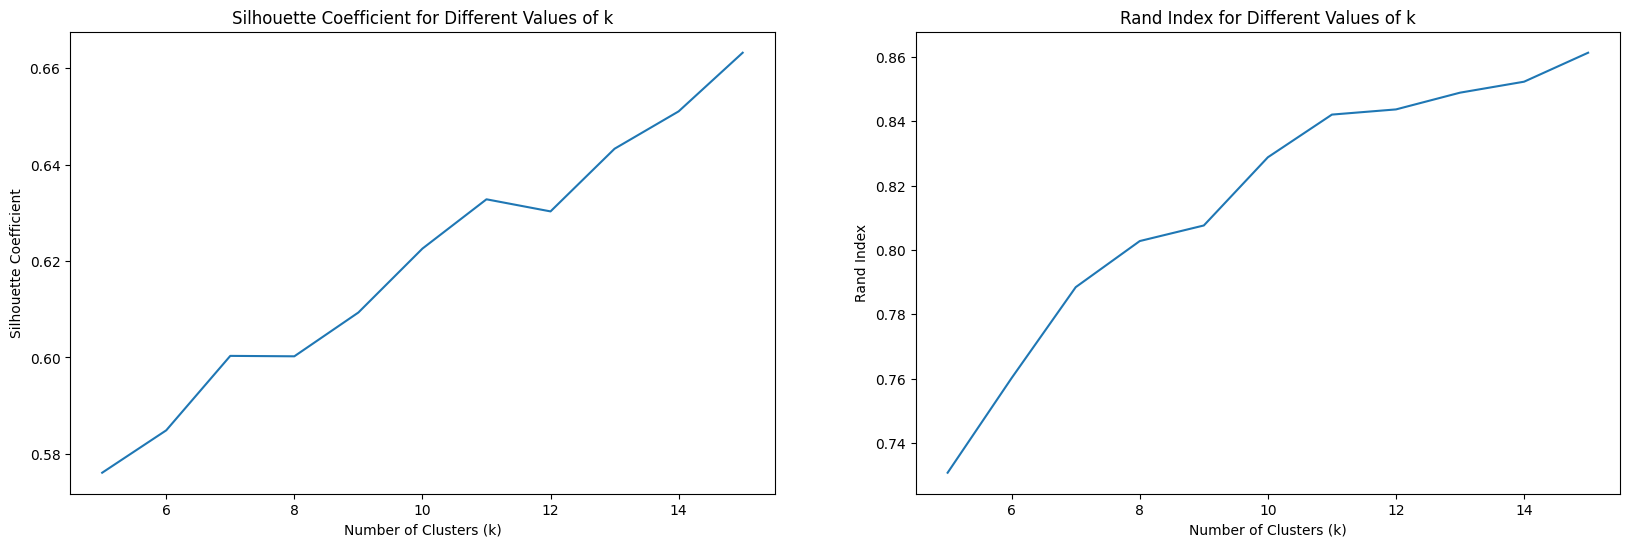

In [51]:
#Asignment 2.2
#k_means part
import matplotlib.pyplot as plt

max_k_sc=0
max_k_ri=0

scs=[]
ris=[]

max_sc=-1
max_ri=-1

for i in range(5,16):
    vowel_labels_k_means=k_means(vowel_data,i)
    sc=silhouette(vowel_data,vowel_labels_k_means)
    ri=Rand(vowel_label,vowel_labels_k_means)
    scs.append(sc)
    ris.append(ri)

    if max_sc<sc:
        max_k_sc=i
    if max_ri<ri:
        max_k_ri=i

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(5,16),scs)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient for Different Values of k')

plt.subplot(1,2,2)
plt.plot(range(5,16),ris)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Rand Index')
plt.title('Rand Index for Different Values of k')
plt.show()   

In [52]:
#nmi calculation
vowel_labels_k_means=k_means(vowel_data,max_k_sc)
print(f"best k by Silhouette is {max_k_sc}, its nmi is {nmi(vowel_label,vowel_labels_k_means)}")

vowel_labels_k_means=k_means(vowel_data,max_k_ri)
print(f"best k by Rand Index is {max_k_ri}, its nmi is {nmi(vowel_label,vowel_labels_k_means)}")

best k by Silhouette is 15, its nmi is 0.20899511718609903
best k by Rand Index is 15, its nmi is 0.20899511718609903


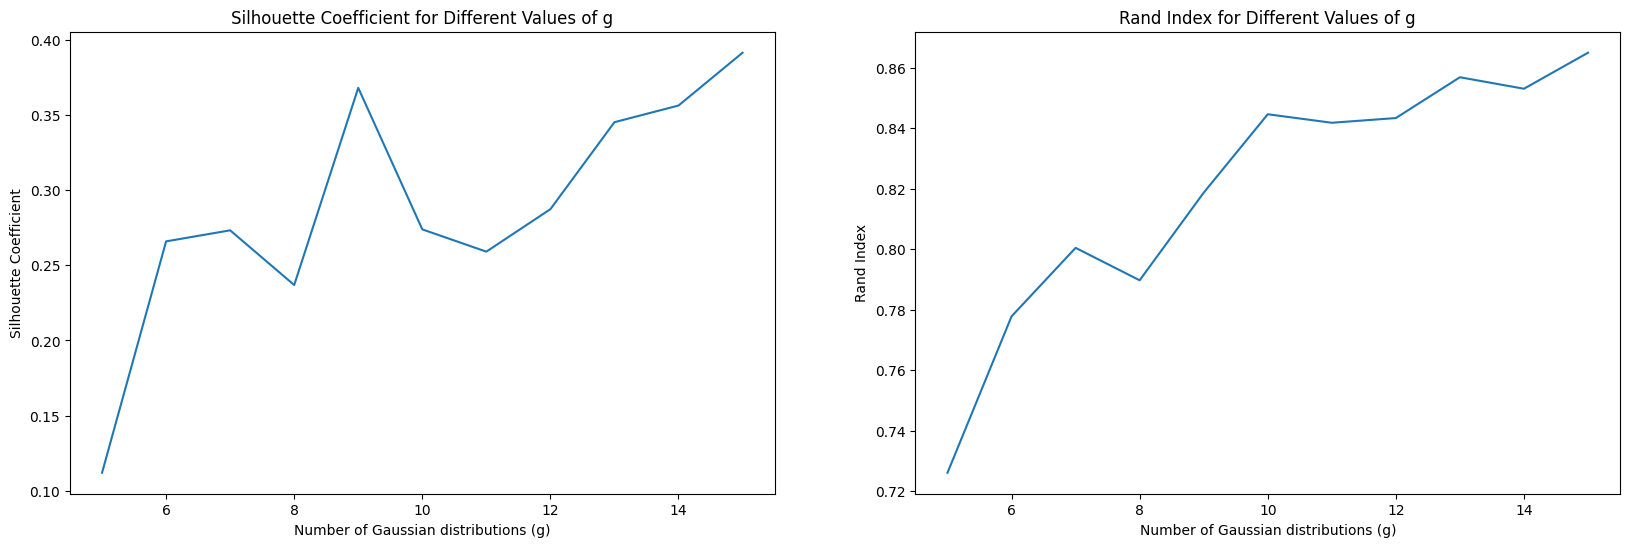

In [53]:
#gmm part
max_k_sc=0
max_k_ri=0

scs=[]
ris=[]
max_sc=-1
max_ri=-1

for i in range(5,16):
    vowel_labels_gmm=gmm(vowel_data,i)
    sc=silhouette(vowel_data,vowel_labels_gmm)
    ri=Rand(vowel_label,vowel_labels_gmm)
    scs.append(sc)
    ris.append(ri)

    if max_sc<sc:
        max_k_sc=i
    if max_ri<ri:
        max_k_ri=i

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(5,16),scs)
plt.xlabel('Number of Gaussian distributions (g)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient for Different Values of g')

plt.subplot(1,2,2)
plt.plot(range(5,16),ris)
plt.xlabel('Number of Gaussian distributions (g)')
plt.ylabel('Rand Index')
plt.title('Rand Index for Different Values of g')
plt.show()  

In [ ]:
#nmi calculation
vowel_labels_gmm=gmm(vowel_data,max_k_sc)
print(f"best k by Silhouette is {max_k_sc}, its nmi is {nmi(vowel_label,vowel_labels_gmm)}")

vowel_labels_gmm=gmm(vowel_data,max_k_ri)
print(f"best k by Rand Index is {max_k_ri}, its nmi is {nmi(vowel_label,vowel_labels_gmm)}")

best k by Silhouette is 15, its nmi is 0.28102475729481496
best k by Rand Index is 15, its nmi is 0.28102475729481496
